# 1. Import libraries and files

In [25]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
from catboost import CatBoostRegressor

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime


# import from previous notebook
import nbimporter
import Model8_four_models as FourModels

# import model
import pickle
import lightgbm
import os
import joblib



In [26]:
# >> enter the model we want to plot here
MODEL_NAME = "xgb_random"
# <<<<<<

In [27]:
# required files
TRAIN_PATH = "../Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "../Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"
OUTPUT_PATH = "./output/"

# data config
DROP_ISTB = True
if "rf" in MODEL_NAME:
    DROP_ISTB = False

# path config
MODEL_SUFFIX = ".sav"
if "lgbm" in MODEL_NAME:
    MODEL_SUFFIX = ".pkl"
    
MODEL_PATH = "./output/model/" + MODEL_NAME + MODEL_SUFFIX


# 2. Plot class

In [28]:
class Plot():
    def __init__(self):
        """pass"""
        # 1. reformat date index for plotting
        self.format_before = '%Y-%m-%d %H:%M:%S'
        self.format_after = '%H:%M'
                
    def plot(self,
             df_bldg,
             scene_name, 
             output_path="",
             is_save=False):
        
        """"A function that plot prediction and scneario or actual values of a single bldg. 
        Will save the images to output path if is_save is set to true"""
    
     
        # 1. grab plot name from the column
        first_plot_name = df_bldg.columns[1]
        second_plot_name = df_bldg.columns[2]
        
        # 2. reformat
        df_bldg.index = pd.to_datetime(df_bldg.index, 
                                    format = self.format_before).strftime(self.format_after)
        # 3. get bldgname
        bldgname = df_bldg["bldgname"][0]

        # 4. compute the difference
        if "actual" in scene_name:
            # (predicted - actual) / actual
            avg_diff = round(((df_bldg[first_plot_name].mean() - 
                    df_bldg[second_plot_name].mean())/df_bldg[second_plot_name].mean())*100,2) 
        else:
            # (scenario - predicted) / predicted
            avg_diff = round(((df_bldg[second_plot_name].mean() - 
                        df_bldg[first_plot_name].mean())/df_bldg[first_plot_name].mean())*100,2)
        
        # 5. predicted plot if its not validation data
        ax = df_bldg.plot(y = first_plot_name, label = first_plot_name, 
                    ylabel = 'CHWTON/SQM', title = bldgname + "[avg diff= " + str(avg_diff) + "%]")

        # 6. second plot: Scenario or actual
        df_bldg.plot(y = second_plot_name, label = second_plot_name, ax=ax)


        # 7. save the image
        if is_save:
            # "./output/predictions_plot/"+ scene_name + "/"
            save_path = output_path + "predictions_plot/"+ scene_name + "/"
            isExist = os.path.exists(save_path)
            if not isExist:

               # Create a new directory because it does not exist
               os.makedirs(save_path)

            fig = ax.get_figure()
            fig.savefig(save_path + bldgname +'_' + scene_name + '.png')
            
                


# 3. Scenario class

In [29]:
"""
This class encapsulates the different scenarios that will be applied to our original data.
We only want to make changes of 0.5 in Air temperature, 0.5 absolute humidity, and 0.2 in shades.
"""
class Scenario():
    def __init__(self, X_test, model):
        # model used to predict
        self.model = model
        
        # data
        # X_test has ISTB_4 if model is CB so we can make scenario prediction
        self.X_test = X_test.copy()
        
        # scenarios
        self.AirTdelta = -0.5 # temperature change
        self.AbsHdelta = -0.5 # absolute humidity
        self.shadeDelta = 0.2
        
    def get_scenario_prediction(self, scenario):
        """
        Given a scenario as a string, this function will make corresponding changes to the X_test dataframe
        and then make prediction using the model initialized in constructor.
        
        Parameter:
            scenario(String) : the variable we want to change in this scenario
            
        Return:
            y_pred_scene : the prediction result
        """
        
        # make copy of X_test_scene so we don't change the actual X_test
        X_test_scene = self.X_test.copy()
        
        # 1. modify X_test according to new scenario
        if scenario == "Air Temp":
            X_test_scene[scenario] += self.AirTdelta
            
        elif scenario == "Abs Hum":
            X_test_scene[scenario] += self.AbsHdelta
        
        elif ("Shade" in scenario):
            print("shade scenario")
            X_test_scene[scenario] += self.shadeDelta
            X_test_scene.loc[X_test_scene[scenario] > 1, scenario] = 1
                
        elif (scenario == "combined"):
            # Air Temp and Abs Hum
            X_test_scene['Air Temp'] = X_test_scene['Air Temp'] + self.AirTdelta
            X_test_scene['Abs Hum'] = X_test_scene['Abs Hum'] + self.AbsHdelta

            # Shading
            shadred = 0.2
            shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
            for facade in shadcol: 
                X_test_scene[facade] = X_test_scene[facade] + shadred
                X_test_scene.loc[X_test_scene[facade] + shadred > 1, facade] = 1
                
        # 2. make prediction
        y_pred_scene = self.model.predict(X_test_scene)
        return y_pred_scene

# 4. Scoring Class

In [30]:
class Scoring():
    
    def __init__(self):
        # create df to store scores per bldg
        columns=['model',
                 'bldgname', 
                 "r2_val", 
                 'r2', 
                 "mae",
                 "mape",
                 "mse",
                 'rmse',
                 'mbe']

        self.df_scores= pd.DataFrame()
        self.combined_name = "combined"
        self.format_5f = "{0:.5f}"
        self.format_7f = "{0:.7f}"
        
    def get_df_scores(self):
        return self.df_scores
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe
    
    def compute_all_metrics(self, df, model_name):
        
        # 0. set bldgname:
        # check if its all bldg or a single bldg
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get all scores
        r2 = r2_score(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        mape = mean_absolute_percentage_error(y_actual, y_pred)
        mse = mean_squared_error(y_actual, y_pred)
        rmse = math.sqrt(mse)
        mbe = self.get_MBE(y_actual, y_pred)
        
        # 3. append score
        # - scores_df to display the scores for all our models
        new_row_data = {'model': model_name, 
                        "bldgname": bldgname, 
                        "r2_val": 0,
                        "r2": self.format_5f.format(r2), 
                        "mae": self.format_5f.format(mae),
                        "mape": self.format_5f.format(mape),
                        "mse": self.format_7f.format(mse),
                        'rmse': self.format_5f.format(rmse), 
                        'mbe': self.format_5f.format(mbe)
                       }
        
        new_row = pd.DataFrame.from_records([new_row_data])
        self.df_scores = pd.concat([self.df_scores, new_row])
        
        
    def compute_r2_val(self, df, model_name):
        
        # 0. set bldgname
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get r2
        r2 = r2_score(y_actual, y_pred)
        self.df_scores.loc[self.df_scores['bldgname']== bldgname, 'r2_val'] = self.format_5f.format(r2)


    def save_scores_csv(self, output_path, model_name):
        self.df_scores.to_csv(OUTPUT_PATH + 'csv/metrics_' + model_name + '.csv', index=False)
    

# 5. Import Data and Model

In [31]:
# 1. Load data
data_obj = FourModels.Data(TRAIN_PATH, TEST_PATH, isDropISTB=DROP_ISTB)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test= data_obj.get_xy_test()

# 2. Load Model
if "lgbm" in MODEL_NAME:
    print("model path=", MODEL_PATH)
    model = joblib.load(MODEL_PATH)

else:
    model = pickle.load(open(MODEL_PATH, 'rb'))

    
# 3. test and confirm correct score
tt = FourModels.TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.test_and_store_score(model, MODEL_NAME)
scores_all = tt.get_scores_df()
print(scores_all)



test and store scores.. xgb_random
r2 test= 0.9804095814324724
        model r2_val  r2_test rmse_test  mbe_test  train_time_s
0  xgb_random      0  0.98041  0.001258  0.000482           0.0


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


# 5. Prediction Plot

## 5.1 Prediction VS Actual

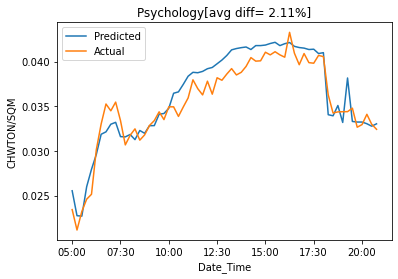

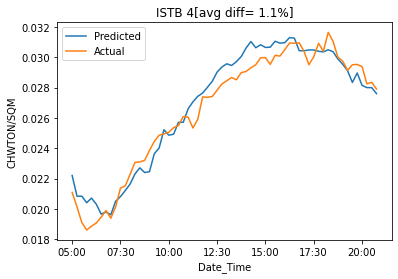

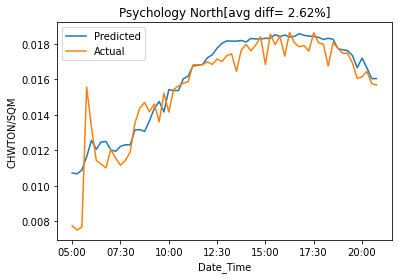

In [32]:
# 1. predict test data and create df_bldgs
y_pred = model.predict(X_test)
df_combined_test, df_bldgs_test = data_obj.create_df_bldgs(y_pred, y_test, is_val=False, is_scenario=False)


# 2. plot
plt_obj = Plot()
for df_bldg in df_bldgs_test:
    plt_obj.plot(df_bldg, "actual", output_path=OUTPUT_PATH, is_save=False)
    


In [33]:
# 3. predict training data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                      y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=20)
y_pred_val = model.predict(X_val)
df_combined_val, df_bldgs_val = data_obj.create_df_bldgs(y_pred_val,
                                                         y_val, is_val=True,
                                                         is_scenario=False)


## Get scores for each bldg

In [34]:
# 1. init scoring object
scoring_obj = Scoring()

# 2. compute scores for each bldg
for df_bldg in df_bldgs_test:
    scoring_obj.compute_all_metrics(df_bldg, MODEL_NAME)
    
for df_bldg in df_bldgs_val:
    scoring_obj.compute_r2_val(df_bldg, MODEL_NAME)
    
    
# # 3. compute scores combined
scoring_obj.compute_all_metrics(df_combined_test, MODEL_NAME)
scoring_obj.compute_r2_val(df_combined_val, MODEL_NAME)

# # 4. grab result
df_scores = scoring_obj.get_df_scores()
df_scores

,model,bldgname,r2_val,r2,mae,mape,mse,rmse,mbe
0,xgb_random,Psychology,0.92807,0.87803,0.00140,0.04012,0.0000027,0.00165,0.00075
0,xgb_random,ISTB 4,0.96227,0.94721,0.00075,0.02952,0.0000008,0.00090,0.00029
0,xgb_random,Psychology North,0.87481,0.84326,0.00075,0.05941,0.0000012,0.00110,0.00041
0,xgb_random,combined,0.98509,0.98041,0.00097,0.04302,0.0000016,0.00126,0.00048


In [35]:
scoring_obj.save_scores_csv(OUTPUT_PATH, MODEL_NAME)

## 5.2 Air Temp Prediction

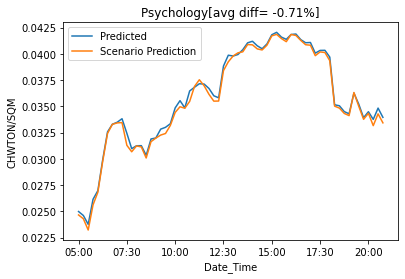

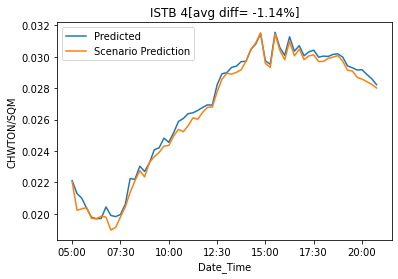

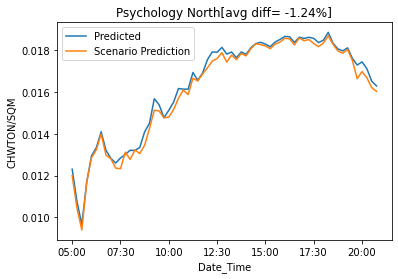

In [12]:
scenario = Scenario(X_test, model)

# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("Air Temp")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False,
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "AirTemp", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

## 5.3 Abs Humidity Prediction

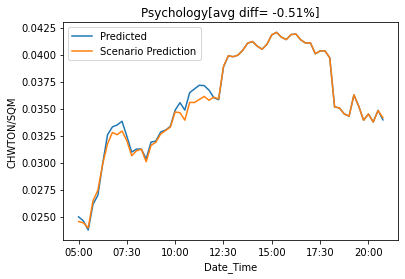

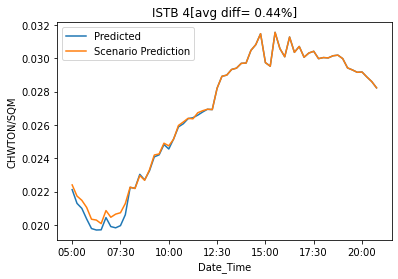

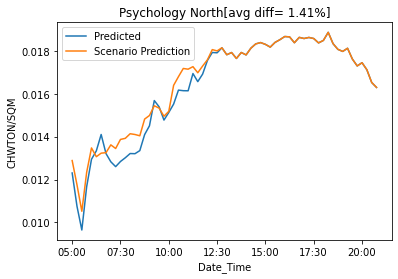

In [13]:
# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("Abs Hum")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False, 
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "AbsHum", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

## 5.4 Shade West Prediction

In [ ]:
# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("Shade West")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False, 
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "ShadeWest", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

## 5.5 Shade East Prediction

In [ ]:
# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("Shade East")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False, 
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "ShadeEast", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

## 5.6. Combined Scenarios

In [ ]:
# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("combined")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False, 
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "combined", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

# 6. Feature Importance

In [ ]:
model.feature_importances_

In [ ]:
## Using Feature Importance
# feature_imp= pd.DataFrame(sorted(zip(model.get_feature_importance(), X_train_val.columns), reverse = True), columns = ['Value', 'Feature'])

# plt.figure(figsize=(7,5))
# sns.barplot(x='Value', y='Feature', data=feature_imp[:20].sort_values(by='Value', ascending=False))
# plt.tight_layout()
# plt.show()

# 7. SHAP

In [ ]:
# 1. init explainer object
explainer = shap.TreeExplainer(model=model,
                           data=None,
                           model_output='raw',
                           feature_perturbation='tree_path_dependent'
                              )

# 2. get shap values from explainer
shap_values = explainer.shap_values(X_test)

# 3. single sample plot
shap.initjs()
i = 7
shap_vals_round = np.array([np.round(x, 3) for x in shap_values[i,:]] )

shap.force_plot(round(explainer.expected_value,3), 
                shap_vals_round, 
                X_test.iloc[i,:].round(decimals = 2), matplotlib = True)

# 4. visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)



In [ ]:
# 5. summary plot
shap.summary_plot(shap_values, X_test, plot_size = [8,6], show = False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)